Notes:
 * tuned fresh and trained on toi data, with toi examples in the validation set
 * adding some of the scalar features into the vetting primry input

In [33]:
import os

chkpt_root = '/mnt/tess/astronet/checkpoints/direct_8_run_1'
data_files = '/mnt/tess/astronet/tfrecords-vetting-7-toi-val/*'
tces_file = '/mnt/tess/astronet/tces-vetting-v5-toi-val.csv'

nruns = 10

def load_ensemble(chkpt_root, nruns):
    checkpts = []
    for i in range(nruns):
        parent = os.path.join(chkpt_root, str(i + 1))
        if not os.path.exists(parent):
            break
        all_dirs = os.listdir(parent)
        if not all_dirs:
            break
        d, = all_dirs
        checkpts.append(os.path.join(parent, d))
    return checkpts

paths = load_ensemble(chkpt_root, nruns)
paths

['/mnt/tess/astronet/checkpoints/direct_8_run_1/1/AstroCNNModelVetting_direct_20211109_224901',
 '/mnt/tess/astronet/checkpoints/direct_8_run_1/2/AstroCNNModelVetting_direct_20211109_230213',
 '/mnt/tess/astronet/checkpoints/direct_8_run_1/3/AstroCNNModelVetting_direct_20211109_231508',
 '/mnt/tess/astronet/checkpoints/direct_8_run_1/4/AstroCNNModelVetting_direct_20211109_232803',
 '/mnt/tess/astronet/checkpoints/direct_8_run_1/5/AstroCNNModelVetting_direct_20211109_234049',
 '/mnt/tess/astronet/checkpoints/direct_8_run_1/6/AstroCNNModelVetting_direct_20211109_235335',
 '/mnt/tess/astronet/checkpoints/direct_8_run_1/7/AstroCNNModelVetting_direct_20211110_000620',
 '/mnt/tess/astronet/checkpoints/direct_8_run_1/8/AstroCNNModelVetting_direct_20211110_001928',
 '/mnt/tess/astronet/checkpoints/direct_8_run_1/9/AstroCNNModelVetting_direct_20211110_003248',
 '/mnt/tess/astronet/checkpoints/direct_8_run_1/10/AstroCNNModelVetting_direct_20211110_004550']

In [34]:
import getpass
import os
from astronet import predict
import tensorflow as tf


def run_predictions(path):
    predict.FLAGS = predict.parser.parse_args([
      '--model_dir', path,
      '--data_files', data_files,
      '--output_file', '',
    ])

    return predict.predict()


paths = load_ensemble(chkpt_root, nruns)
ensemble_preds = []
config = None
for i, path in enumerate(paths):
    print(f'Running model {i + 1}')
    preds, config = run_predictions(path)
    ensemble_preds.append(preds.set_index('tic_id'))
    print()

Running model 1
354 records
Running model 2
354 records
Running model 3
354 records
Running model 4
354 records
Running model 5
354 records
Running model 6
354 records
Running model 7
354 records
Running model 8
354 records
Running model 9
354 records
Running model 10
354 records


In [35]:
labels = ['disp_p', 'disp_e', 'disp_n']

col_p = labels.index('disp_p')
# thresh = 0.1579816417694639
thresh = 0.99

In [36]:
all_preds_table = ensemble_preds[0].copy()
all_preds_table['model'] = 0

for i in range(len(ensemble_preds[1:])):
    tmp = ensemble_preds[i].copy()
    tmp['model'] = i
    all_preds_table = all_preds_table.append(tmp)
    
all_preds_table.to_csv('toi_ensemble_preds.csv')

In [57]:
import numpy as np
import pandas as pd

agg_preds = {}

mean_preds = preds.groupby(['tic_id']).mean()

# for tic_id in mean_preds.index:
#     agg_preds[tic_id] = []

#     row = mean_preds[mean_preds.index == tic_id]
#     pred_v = row.values[0]
#     if len(row.values) > 1:
#         print(f'Warning: duplicate predictions for {tic_id}')
#     if pred_v[col_p] >= thresh:
#         agg_preds[tic_id].append('disp_p')
#     else:
#         agg_preds[tic_id].append(mean_preds.columns[np.argmax(pred_v)])

for preds in ensemble_preds:
    for tic_id in mean_preds.index:
        if tic_id not in agg_preds:
            agg_preds[tic_id] = []

        row = preds[preds.index == tic_id]
        pred_v = row.values[0]
        if len(row.values) > 1:
            print(f'Warning: duplicate predictions for {tic_id}')
        if pred_v[col_p] >= thresh:
            agg_preds[tic_id].append('disp_p')
        else:
            agg_preds[tic_id].append(preds.columns[np.argmax(pred_v)])

In [58]:
final_preds = []
for tic_id in list(agg_preds.keys()):
    counts = {l: 0 for l in labels}
    for e in agg_preds[tic_id]:
        counts[e] += 1
    maxcount = max(counts.values())
    counts.update({
        'tic_id': tic_id,
        'maxcount': maxcount,
    })
    final_preds.append(counts)
    
final_preds = pd.DataFrame(final_preds).set_index('tic_id')

In [59]:
tce_table = pd.read_csv(tces_file, header=0).set_index('tic_id')
tce_labels = tce_table[labels]

pl = final_preds.join(tce_labels, on='tic_id', how='left', lsuffix='_p')

pl.head()
pd.set_option('display.max_columns', None)

In [60]:
ppos = (pl['disp_p_p'] > 0)
pos = (pl['disp_p'] > 0)

pneg = (pl['disp_p_p'] == 0)
neg = (pl['disp_p'] == 0)

print('Recall:', len(pl[ppos & pos]) / len(pl[pos]))
print('Precision:', len(pl[ppos & pos]) / len(pl[ppos]))

Recall: 1.0
Precision: 0.8208092485549133


In [61]:
for i in pl[pos & pneg][[]].join(tce_table, on='tic_id', how='left').index:
    print(i)

In [62]:
for i in pl[neg & ppos][[]].join(tce_table, on='tic_id', how='left').index:
    print(i)

23826331
24004619
24491836
30275619
74934381
98350979
119774374
137778682
149854222
255994336
271903247
276645751
276936320
278225267
278866211
280095254
304729846
307153959
321828403
344978642
365494323
372222115
380783252
384068226
384744828
388076435
424876542
457138169
469782185
1715469662
1715469667


In [63]:
def compare(ensemble_preds, filter):
    result = ensemble_preds[0][filter]
    for preds in ensemble_preds[1:]:
        result = result.append(preds[filter])
    return result

compare(ensemble_preds, preds.index == 1129033)

,disp_p,disp_e,disp_n
tic_id,,,
1129033,0.948481,0.051030,0.000489
1129033,0.957662,0.041880,0.000458
1129033,0.982877,0.016772,0.000351
1129033,0.908593,0.090588,0.000820
1129033,0.895006,0.104184,0.000810
1129033,0.964925,0.033950,0.001125
1129033,0.938501,0.060876,0.000623
1129033,0.948832,0.050647,0.000522
1129033,0.902322,0.096588,0.001090


### PR curve

In [64]:
tics = set(ensemble_preds[0].index.values)

tic_index = {v: i for i, v in enumerate(tics)}

pred_ps = np.zeros([len(ensemble_preds), len(tic_index)])
pred_es = np.zeros([len(ensemble_preds), len(tic_index)])
pred_ns = np.zeros([len(ensemble_preds), len(tic_index)])
for i, preds in enumerate(ensemble_preds):
    for row in preds.iterrows():
        tic, pred_p = row[0], row[1][col_p]
        pred_ps[i][tic_index[tic]] = pred_p
        pred_es[i][tic_index[tic]] = row[1][labels.index('disp_e')]
        pred_ns[i][tic_index[tic]] = row[1][labels.index('disp_n')]

lbl_ps = np.zeros([len(tic_index)], dtype=np.bool)
bad_labels = []
for row in tce_labels.iterrows():
    tic, lbl_p = row[0], row[1]['disp_p']
    if tic in tic_index:
        lbl_ps[tic_index[tic]] = (lbl_p > 0)
    else:
        bad_labels.append(tic)

In [65]:
num_cond_pos = float(np.sum(lbl_ps))

def pr_at_th(th):
    pred_pos = np.any(pred_ps >= th, axis=0)
    true_pos = pred_pos & lbl_ps
    num_pred_pos = int(np.sum(pred_pos))
    num_true_pos = int(np.sum(true_pos))
    if num_pred_pos == 0:
        return 1.0, 0.0
    return float(num_true_pos) / float(num_pred_pos), float(num_true_pos) / float(num_cond_pos)

AUC: 0.9722333255511563, max R: 1.0, max P: 1.0
100% recall at: 82%, threshold: 0.47649988079076544


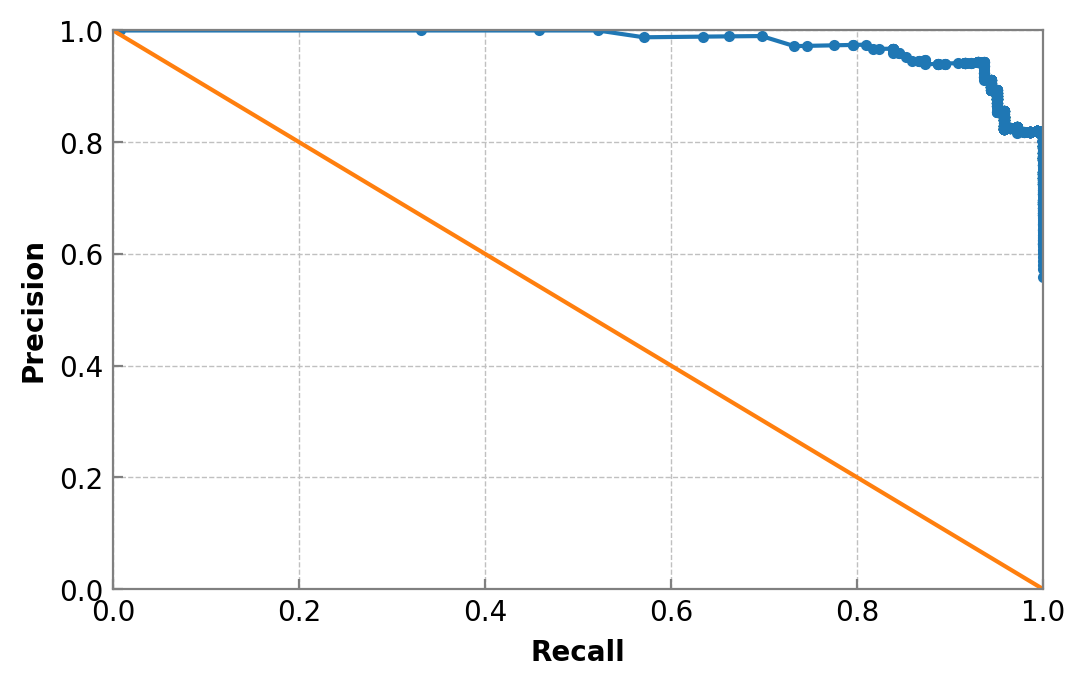

In [66]:
from matplotlib import pyplot as plt

ps, rs, ths = ([], [], [])
th = np.max(pred_ps)
while th >= 0.0:
    p, r = pr_at_th(th)
    if p > 0:
        ps.append(p)
        rs.append(r)
    else:
        ps.append(1.0)
        rs.append(0.0)
    ths.append(th)
    th -= 0.0005
    
from sklearn import metrics

print(f'AUC: {metrics.auc(rs, ps)}, max R: {max(rs)}, max P: {max(ps)}')
    
i = len(rs) - 1
while rs[i] == 1.0:
    i -= 1
i += 1
print(f'100% recall at: {int(ps[i] * 100)}%, threshold: {ths[i]}')

fig, ax = plt.subplots(figsize=(6, 3.7), dpi=200)

ax.spines['top'].set_color('#808080')
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.spines['bottom'].set_color('#808080')
ax.tick_params(direction='in', color='#808080')

plt.grid(color='#c0c0c0', linestyle='--', linewidth=0.5)

plt.ylabel('Precision', fontweight='bold')
plt.xlabel('Recall', fontweight='bold')

plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))

_ = plt.plot(rs, ps, marker='.')
_ = plt.plot([0.0, 1.0], [1.0, 0.0])